# Undistortion and Unprojection

In this tutorial, we will show you how to convert 2d pixel locations into 3d points
in camera coordinates. In Pupil Core software, this technique is used to generate
cyclopean 3d gaze directions from 2d gaze estimates.

To transform between the different coordinate systems, we use camera "intrinsics". They
consist of the camera matrix and the distortion coefficients. The former contains
information about the camera's principle point and focal length. The latter information
about the lens' distortion properties.

To read more about these technical terms, see this
[OpenCV tutorial](https://docs.opencv.org/4.x/dc/dbb/tutorial_py_calibration.html).

There are various [distortion models](https://learnopencv.com/understanding-lens-distortion/).
This tutorial will use *radial* and *tangential* distortion models. To handle fisheye
distortion, use the corresponding [`cv2.fisheye`](https://docs.opencv.org/4.5.5/db/d58/group__calib3d__fisheye.html)
functions.

## Coordinate Systems

There are four relevant coordinate systems for this tutorial:
1. Distorted image space - This is the coordinate system of the recorded video frames
    and 2d gaze estimates. Points are two-dimensional and affected by lens distortion.
2. Undistorted image space - This is an intermediate coordinate system in which points
    remain two-dimensional but are no longer affected by distortion. Undistorted images
    are better suited for tasks like object detection but are computationally expensive
    to generate. This tutorial will concentrate on (un)distorting sparse points instead
    of whole images.
3. [Undistorted camera space](https://docs.opencv.org/3.4/d9/d0c/group__calib3d.html) -
    A three-dimensional cartesian coordinate system that is not affected by lens
    distortion. Pupil Core software uses this coordinate system for estimating 3d
    values, e.g. `gaze_point_3d`.
4. [Horizontal coordinate system](https://en.wikipedia.org/wiki/Horizontal_coordinate_system) -
    In this coordinate system, a direction to an object is given in two angles:
    elevation (vertical angle) and azimuth (horizontal angle). This coordinate system is
    especially useful to calculate angular velocities. In this tutorial, the angle
    values are relative to the camera's optical axis (straight out; `(0,0,1)` in
    cartesian coordinates). The distance between a point and the origin is named radius.

| Values   | Azimuth    | Elevation  |
| -------- | ---------- | ---------- |
| negative | left half  | lower half |
| positive | right half | upper half |


In [1]:
from google.colab import drive
drive.mount('/content/drive')
!unzip /content/drive/MyDrive/sample_recording_v2.zip

Mounted at /content/drive
Archive:  /content/drive/MyDrive/sample_recording_v2.zip
   creating: sample_recording_v2/
  inflating: sample_recording_v2/eye1_timestamps.npy  
  inflating: sample_recording_v2/notify_timestamps.npy  
  inflating: sample_recording_v2/gaze_timestamps.npy  
  inflating: sample_recording_v2/pupil.pldata  
  inflating: sample_recording_v2/world.intrinsics  
  inflating: sample_recording_v2/eye0_lookup.npy  
  inflating: sample_recording_v2/world_timestamps.npy  
  inflating: sample_recording_v2/eye0.mp4  
  inflating: sample_recording_v2/eye0_timestamps.npy  
  inflating: sample_recording_v2/world.mp4  
  inflating: sample_recording_v2/square_marker_cache  
  inflating: sample_recording_v2/notify.pldata  
  inflating: sample_recording_v2/surface_definitions_v01  
  inflating: sample_recording_v2/eye1.mp4  
  inflating: sample_recording_v2/pupil_timestamps.npy  
  inflating: sample_recording_v2/surface_definitions  
  inflating: sample_recording_v2/eye1_lookup.np

## Tutorial Python Requirements

To (un)distort and (un)project points, we will use OpenCV. You can read more about how
OpenCV handles camera models and their distortion [here](https://docs.opencv.org/4.x/dc/dbb/tutorial_py_calibration.html).
```
pip install opencv-python
```

We use matplotlib to visualize points in 2d and 3d.
```
pip install matplotlib
```

To load stored intrinsics from Pupil Core recordings, we will need msgpack.
```
pip install msgpack
```

In [2]:
import pathlib
import pprint

import cv2  # pip install opencv-python
import numpy as np  # installed as part of OpenCV
import matplotlib.pyplot as plt  # pip install matplotlib
import msgpack  # pip install msgpack

try:
    # Optional: seaborn for consistent plot styles
    import seaborn as sns  # pip install seaborn

    sns.set()
except ImportError:
    pass


## Defining the Transformation Functions

OpenCV is very picky regarding the data type and shape of the points that it takes as
input for the distortion/projection functions. A partial goal of this tutorial is to
provide you with reusable functions that takes care of these details for you.

See the next section *Using the Transformation Functions* on how to use them in practice.

In [3]:
def unproject_with_distortion(points_2d, camera_matrix, dist_coefs, normalize=False):
    """Transforms points from distorted image space to the undistorted camera space.

    `normalize` determines wether the output points lie on a plane or a sphere.

    Input shape: (N,2)
    Output shape: (N,3)
    """
    return _unproject_points(
        points_2d, camera_matrix, dist_coefs=dist_coefs, normalize=normalize
    )


def unproject_without_distortion(points_2d, camera_matrix, normalize=False):
    """Transforms points from undistorted image space to the undistorted camera space.

    `normalize` determines wether the output points lie on a plane or a sphere.

    Input shape: (N,2)
    Output shape: (N,3)
    """
    return _unproject_points(
        points_2d, camera_matrix, dist_coefs=None, normalize=normalize
    )


def project_with_distortion(points_3d, camera_matrix, dist_coefs):
    """Transforms points from the undistorted camera space to distorted image space

    Input shape: (N,3)
    Output shape: (N,2)
    """
    return _project_points(points_3d, camera_matrix, dist_coefs)


def project_without_distortion(points_3d, camera_matrix):
    """Transforms points from the undistorted camera space to undistorted image space

    Input shape: (N,3)
    Output shape: (N,2)
    """
    return _project_points(points_3d, camera_matrix, dist_coefs=None)


def _unproject_points(points_2d, camera_matrix, dist_coefs, normalize: bool):
    """Transforms points either from
    - the distorted image space (dist_coefs=dist_coefs)
    - the undistorted image space (dist_coefs=None)
    to the undistorted camera space.

    `normalize` determines wether the output points lie on a plane or a sphere.

    Input shape: (N,2)
    Output shape: (N,3)
    """
    points_2d = np.asarray(points_2d, dtype="float64")
    camera_matrix = np.asarray(camera_matrix)
    if dist_coefs is None:
        dist_coefs = np.asarray([[0.0, 0.0, 0.0, 0.0, 0.0]])
    else:
        dist_coefs = np.asarray(dist_coefs)

    points_2d = cv2.undistortPoints(points_2d, camera_matrix, dist_coefs)

    points_3d = cv2.convertPointsToHomogeneous(points_2d)
    points_3d.shape = -1, 3

    if normalize:
        points_3d /= np.linalg.norm(points_3d, axis=1)[:, np.newaxis]

    return points_3d


def _project_points(points_3d, camera_matrix, dist_coefs):
    """Transforms points from the undistorted camera space either to
    - undistorted image space (with `dist_coefs=None`)
    - distorted image space (with `dist_coefs=dist_coefs`)

    Input shape: (N,3)
    Output shape: (N,2)
    """
    points_3d = np.asarray(points_3d, dtype="float64").reshape((1, -1, 3))
    camera_matrix = np.asarray(camera_matrix)
    if dist_coefs is None:
        dist_coefs = np.asarray([[0.0, 0.0, 0.0, 0.0, 0.0]])
    else:
        dist_coefs = np.asarray(dist_coefs)

    # rotation and translation of the camera, zero in our case
    rvec = tvec = np.zeros((1, 1, 3))

    points_2d, _ = cv2.projectPoints(points_3d, rvec, tvec, camera_matrix, dist_coefs)
    return points_2d.reshape(-1, 2)


def undistort_points_2d(points_2d, camera_matrix, dist_coefs):
    """Transforms points from the distorted to the undistorted image space

    Input shape: (N,2)
    Output shape: (N,2)
    """
    points_3d = unproject_with_distortion(points_2d, camera_matrix, dist_coefs)
    return project_without_distortion(points_3d, camera_matrix)


def distort_points_2d(points_2d, camera_matrix, dist_coefs):
    """Transforms points from the undistorted to the distorted image space

    Input shape: (N,2)
    Output shape: (N,2)
    """
    points_3d = unproject_without_distortion(points_2d, camera_matrix)
    return project_with_distortion(points_3d, camera_matrix, dist_coefs)


def cartesian_to_horizontal(points_3d, apply_rad2deg=True):
    """Transforms points from the undistorted 3d cartesian camera space to the
    horizontal coordinate system.

    Input shape: (N,3)
    Output shape: (N,),(N,),(N,)
    """
    # source: http://stackoverflow.com/questions/4116658/faster-numpy-cartesian-to-spherical-coordinate-conversion
    x = points_3d[:, 0]
    y = points_3d[:, 1]
    z = points_3d[:, 2]
    radius = np.sqrt(x**2 + y**2 + z**2)
    # elevation: vertical direction
    #   positive numbers point up
    #   negative numbers point bottom
    elevation = np.arccos(y / radius) - np.pi / 2
    # azimuth: horizontal direction
    #   positive numbers point right
    #   negative numbers point left
    azimuth = np.pi / 2 - np.arctan2(z, x)

    if apply_rad2deg:
        elevation = np.rad2deg(elevation)
        azimuth = np.rad2deg(azimuth)

    return azimuth, elevation, radius


## Using the Transformation Functions

### Camera Intrinsics

To use the transformation functions, we need a camera matrix and distortion coefficients.
In this tutorial, we will use Pupil Capture's default intrinsics for the Pupil Core
wide-angle lens at a resolution of 1280x720.

You can find all default intrinsics [here](https://github.com/pupil-labs/pupil/blob/master/pupil_src/shared_modules/camera_models.py#L27-L162).

In [4]:
resolution = 1280, 720
camera_matrix = [
    [773.1676910077922, 0.0, 646.7114347564985],
    [0.0, 743.1525324268981, 363.1646522363395],
    [0.0, 0.0, 1.0],
]

dist_coefs = [
    [
        0.10152808562655541,
        -0.23953332793667598,
        -0.0021208895917640205,
        -0.00023898995918166237,
        0.1098748288957075,
    ]
]


### Point Grid

To demonstrate the effect of the transformation, we will start with a sparse point grid
in undistorted image space. This is comparable to the corners on a chess field.

In [5]:
point_distance = 20
x, y = np.meshgrid(
    np.arange(0, resolution[0] + 1, point_distance),
    np.arange(0, resolution[1] + 1, point_distance),
)
points_2d_undist = np.concatenate(
    [x.reshape(-1, 1), y.reshape(-1, 1)], axis=1
)  # shape: Nx2


To track each point across the transformation, we will assign a unique RGB value to each of them.
The colors are interpolated based on the point's location on the 2d grid:

| **yellow**|**green** |
| ----------|--------- |
| **red**   |**blue**  |

In [6]:
R = np.linspace(1, 0, x.shape[1])
G = np.linspace(1, 0, x.shape[0])
R, G = np.meshgrid(R, G)
rg = np.concatenate([R.reshape(-1, 1), G.reshape(-1, 1)], axis=1)
B = ([1, 1] - rg) @ [1, 1]
B /= B.max()
rgb = np.concatenate([rg, B[..., np.newaxis]], axis=1)  # shape: Nx3


def plot_2d(points_2d, title):
    figure, ax = plt.subplots(figsize=(12, 7))
    ax.scatter(points_2d[:, 0], points_2d[:, 1], c=rgb, edgecolors="gray")
    ax.invert_yaxis()  # in image space, the origin is in the top left
    ax.set_title(title)
    figure.tight_layout()


def plot_3d(points_3d, title):
    figure, ax = plt.subplots(figsize=(12, 7), subplot_kw=dict(projection="3d"))
    ax.scatter(
        points_3d[:, 0],
        points_3d[:, 1],
        points_3d[:, 2],
        label="grid",
        color=rgb,
        edgecolors="gray",
    )
    ax.scatter(0, 0, 0, marker="x", label="origin")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title(title)
    ax.legend()
    figure.tight_layout()


def plot_horizontal(azimuth, elevation, title):
    figure, ax = plt.subplots(figsize=(12, 7))
    ax.scatter(
        azimuth,
        elevation,
        label="grid",
        color=rgb,
        edgecolors="gray",
    )
    ax.set_xlabel("azimuth [deg]")
    ax.set_ylabel("elevation [deg]")
    ax.set_title(title)
    ax.legend()
    figure.tight_layout()


### Transformations

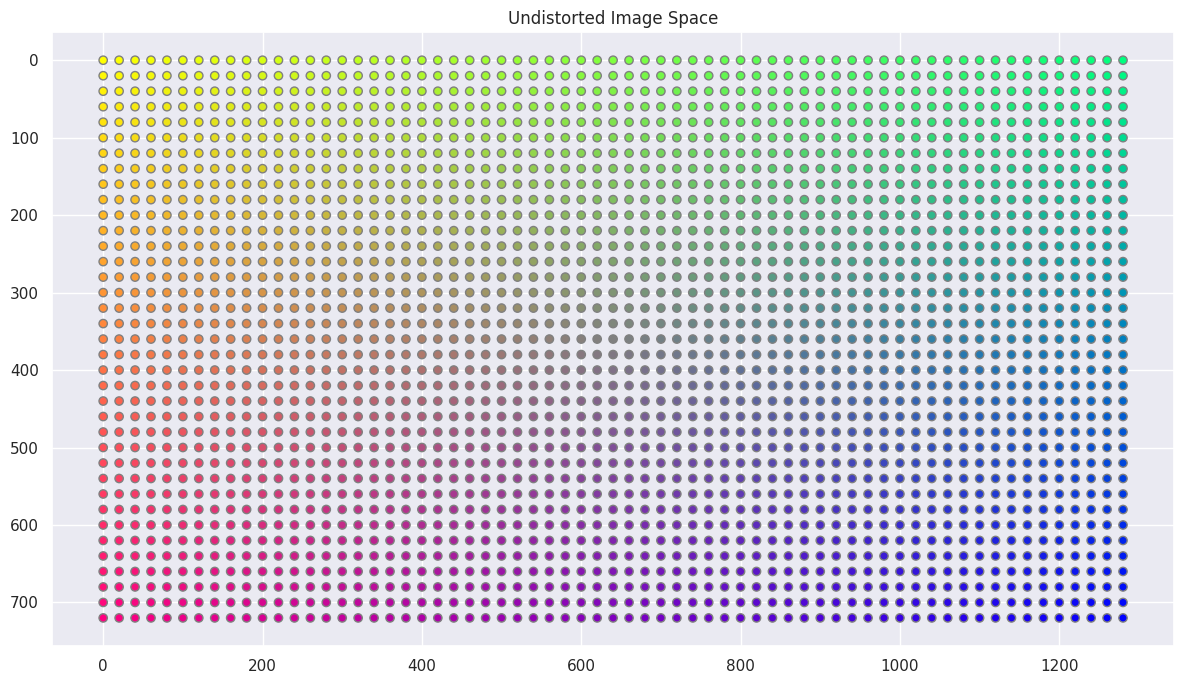

In [7]:
plot_2d(points_2d_undist, "Undistorted Image Space")


The first transformation distorts the points within the image space. The result is similar
to how chessboard corners would look like in the video stream.

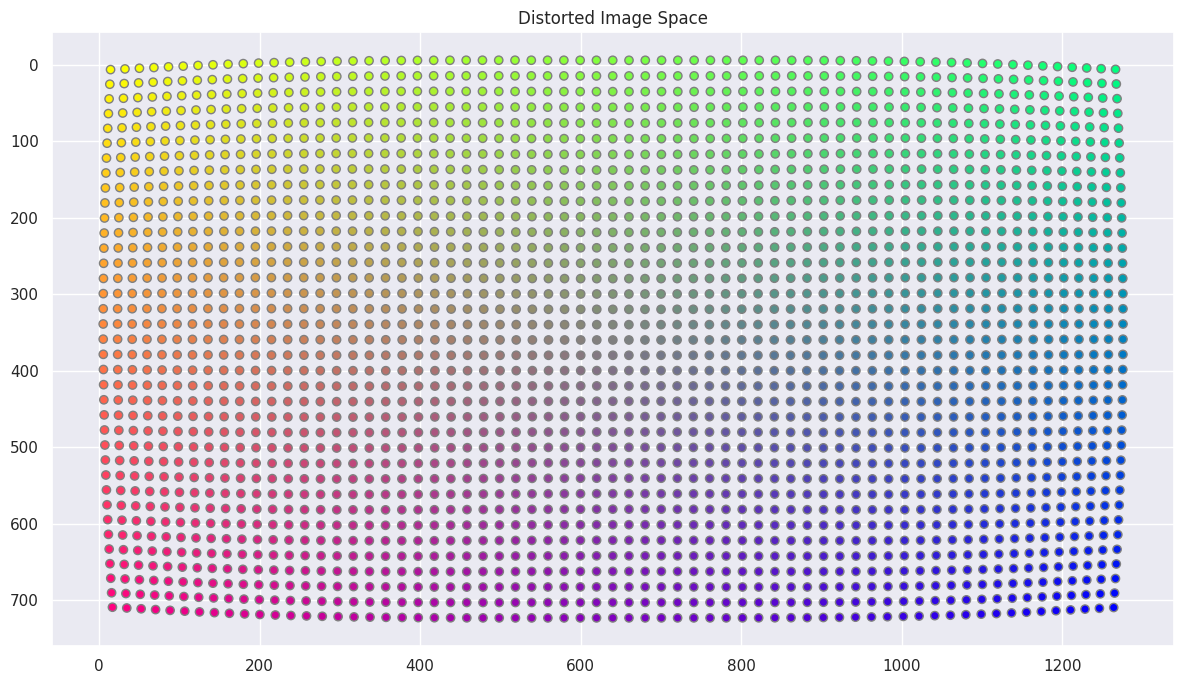

In [8]:
points_2d_dist = distort_points_2d(points_2d_undist, camera_matrix, dist_coefs)
plot_2d(points_2d_dist, title="Distorted Image Space")


Next, we transform the undistorted 2d image space locations into undistorted 3d camera
coordinates. Here, we can choose wether we want the resulting 3d points to lie
- on a plane with z=1 (`normalize=False`)
- on a sphere with radius=1 (`normalize=True`)

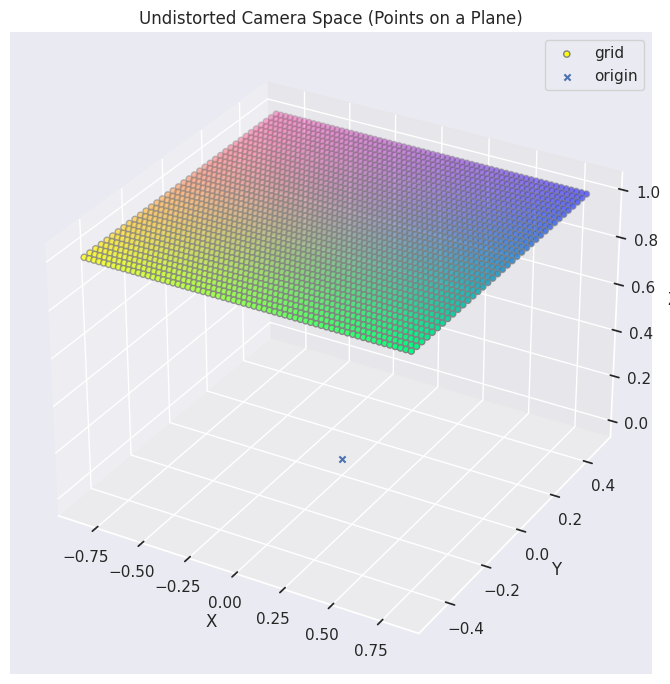

In [9]:
points_3d_plane = unproject_without_distortion(
    points_2d_undist, camera_matrix, normalize=False
)
plot_3d(points_3d_plane, title="Undistorted Camera Space (Points on a Plane)")


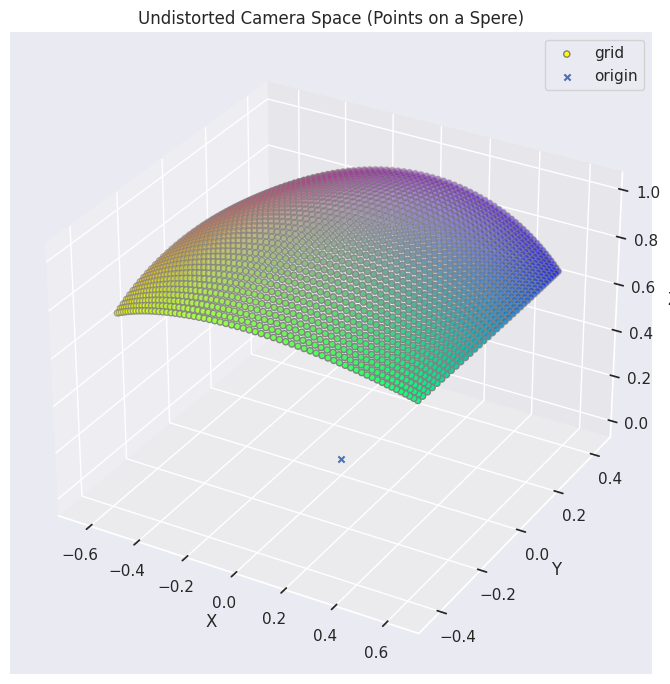

In [10]:
# only difference to above: normalize=True
points_3d_sphere = unproject_without_distortion(
    points_2d_undist, camera_matrix, normalize=True
)
plot_3d(points_3d_sphere, title="Undistorted Camera Space (Points on a Spere)")


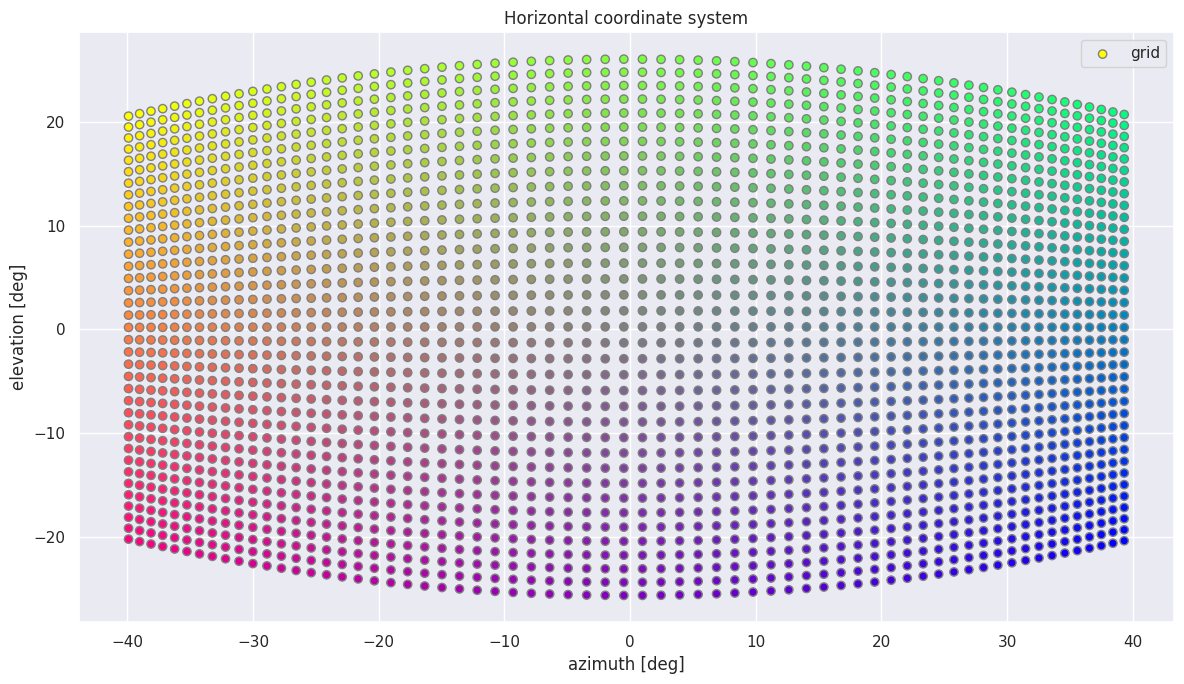

In [11]:
azimuth, elevation, _ = cartesian_to_horizontal(points_3d_plane, apply_rad2deg=True)
plot_horizontal(azimuth, elevation, title="Horizontal coordinate system")


## Reading Intrinsics From Pupil Core Recordings

Pupil Core software stores each camera's intrinsics to a corresponding file, e.g.
`world.intrinsics`, during the recording. This allows the analyse software, e.g. Pupil
Player, to load different intrinsics for each recorded video.

The intrinsics are stored as mapping/dictionary in a [msgpack](https://msgpack.org/) file.

To support multiple possible resolutions, the mapping has a resolution-based top-level
key for every stored intrinsics. The example below only contains intrinsics for the
1280x720 resolution.

For each resolution, the file stores the camera matrix, distortion coefficients, and
the camera type (`radial` or `fisheye`).

In [15]:
# List recording content
recording_location = "/content/sample_recording_v2"
recording_location = pathlib.Path(recording_location)

intrinsics_location = recording_location / "world.intrinsics"
assert intrinsics_location.exists()

with intrinsics_location.open("rb") as fh:
    intrinsics = msgpack.unpack(fh)

pprint.pprint(intrinsics)


{'(1280, 720)': {'cam_type': 'radial',
                 'camera_matrix': [[829.3510515270362, 0.0, 659.9293047259697],
                                   [0.0, 799.5709408845464, 373.0776462356668],
                                   [0.0, 0.0, 1.0]],
                 'dist_coefs': [[-0.43738542863224966,
                                 0.190570781428104,
                                 -0.00125233833830639,
                                 0.0018723428760170056,
                                 -0.039219091259637684]],
                 'resolution': [1280, 720]},
 'version': 1}
